In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt # type: module
import matplotlib.ticker as ticker

import numpy as np
import os, glob
import time
import warnings

from rur.fortranfile import FortranFile
from rur import uri, uhmi, painter, drawer
from rur.sci.photometry import measure_luminosity
from rur.sci.geometry import get_angles, euler_angle
from rur.utool import rotate_data
from scipy.ndimage import gaussian_filter
uri.timer.verbose=0
# from rur.sci.kinematics import f_getpot

from icl_IO import mode2repo, pklsave, pklload
from icl_tool import *
from icl_numba import large_isin, large_isind, isin
from icl_draw import drawsnap, add_scalebar, addtext, MakeSub_nolabel, label_to_in, fancy_axis, circle
import argparse, subprocess
from importlib import reload
import cmasher as cmr

In [3]:
mode = 'nh'
iout = 1026
repo, rurmode, dp = mode2repo(mode)
snap = uri.RamsesSnapshot(repo, iout, mode=rurmode)
snaps = uri.TimeSeries(snap)
snaps.read_iout_avail()
nout = snaps.iout_avail['iout']
gals1 = uhmi.HaloMaker.load(snap, galaxy=True, double_precision=dp)
gals2 = pklload("./database/01_nh_ghmatch.pickle")
hals = uhmi.HaloMaker.load(snap, galaxy=False, double_precision=dp)
LG = pklload(f"./database/11_LocalGroup.pickle")

In [5]:
LG[11]['BGG']

(2993316, 11, 1026, 1, 11, 0, 13, 1866, 0.85361391, 2.62908526e+10, 0.46406026, 0.55255657, 0.5271388, 99.66107271, -56.61125125, 91.9142631, 4.03284931e+09, -1.23927936e+10, 7.97734209e+09, 0.00039021, 0.00457166, 0.00173924, 0.00437453, 2998.13850691, -2535.32681102, 462.81169589, 0.2156497, 82.97014315, 73.50218319, 0.16980676, 0.00035074, 2.62908526e+10, 95455.27673771, 51.56472869, 272.01249927, 0.00035074, 24674, 228, 4, 5476, 24673, 0.46429781, 0.55276958, 0.52698964, 75.4522647, 33.73348437, 208.43704681, 2.97587956e+08, 2.83004261e-05, 0., 0.00035221, True, False, 7.37979157, 74465629.39386748, 6.08632665e-05, 27291959.198342, 4740087.00273832, 0., 7.00935296e-05, 0.00558706, 0.00033861, 10, 5704, 9.43010871e-05)

In [12]:
MWA.dtype

dtype([('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('sigma_bulge', '<f8'), ('m_bulge', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('halo_id', '<i4'), ('halo_nparts', '<i4'), ('halo_level', '<i4'), ('halo_host', '<i4'), ('halo_hostsub', '<i4'), ('halo_x', '<f8'), ('halo_y', '<f8'), ('halo_z', '<f8'), ('halo_vx', '<f8'), ('halo_vy', '<f8'), ('halo_vz', '<f8'), ('halo_mvir', '<f8'), ('halo_rvir', '<f8'), ('fcontam', '<f8'), ('dist', '<f8'), ('central', '?'), ('main', '?'), ('r200', '<f8'), ('m200', '<f8'), ('r200_code', '<f8'), (

## Rematch the host halo

In [15]:
'nh2' in 'halo_nh2'

True

24588
<class 'numpy.ndarray'> [('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f8'), ('m', '<f8'), ('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('vx', '<f8'), ('vy', '<f8'), ('vz', '<f8'), ('Lx', '<f8'), ('Ly', '<f8'), ('Lz', '<f8'), ('r', '<f8'), ('a', '<f8'), ('b', '<f8'), ('c', '<f8'), ('ek', '<f8'), ('ep', '<f8'), ('et', '<f8'), ('spin', '<f8'), ('sigma', '<f8'), ('sigma_bulge', '<f8'), ('m_bulge', '<f8'), ('rvir', '<f8'), ('mvir', '<f8'), ('tvir', '<f8'), ('cvel', '<f8'), ('rho0', '<f8'), ('rc', '<f8'), ('halo_id', '<i4'), ('halo_nparts', '<i4'), ('halo_level', '<i4'), ('halo_host', '<i4'), ('halo_hostsub', '<i4'), ('halo_x', '<f8'), ('halo_y', '<f8'), ('halo_z', '<f8'), ('halo_vx', '<f8'), ('halo_vy', '<f8'), ('halo_vz', '<f8'), ('halo_mvir', '<f8'), ('halo_rvir', '<f8'), ('fcontam', '<f8'), ('dist', '<f8'), ('central', '?'), ('main', '?'), ('r200', '<f8'), ('m200', '<f8'),

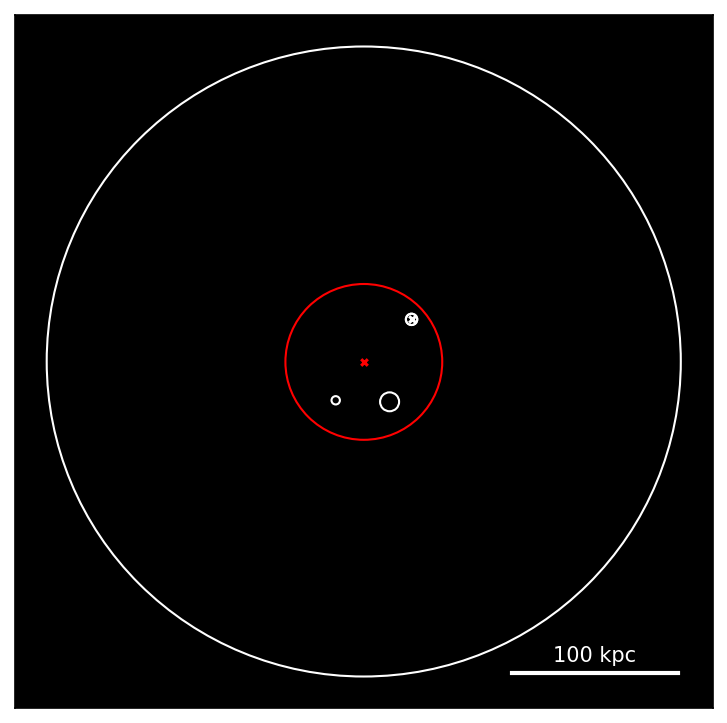

In [30]:
MWA = LG[11]['BGG']
hal = hals[MWA['halo_id']-1]

fig, ax = fancy_axis(figsize=(6,6), dpi=150)

ax.scatter(hal['x'], hal['y'], s=10, c='w', marker='x')
ax.scatter(MWA['x'], MWA['y'], s=10, c='r', marker='x')

cir = plt.Circle((MWA['x'], MWA['y']), MWA['r'], color='r', fill=False)
ax.add_patch(cir)
cir = plt.Circle((hal['x'], hal['y']), hal['rvir'], color='w', fill=False)
ax.add_patch(cir)

hosts = cut_sphere(hals, MWA['x'], MWA['y'], MWA['z'], MWA['r'])
argmax = np.argmax(hosts['rvir'])
for host in hosts:
    cir = plt.Circle((host['x'], host['y']), host['rvir'], color='w', fill=False)
    ax.add_patch(cir)
realhost = hosts[argmax]
print(realhost['id'])

dtype = MWA.dtype
MWA = np.array(MWA)
print(type(MWA), MWA.dtype)
print(MWA)
for iname, descr in zip(dtype.names, dtype.descr):
    if(iname[:5]=='halo_')and(not 'nh2' in iname):
        print(iname)
        print(MWA[iname],realhost[iname[5:]])
        MWA[iname] = realhost[iname[5:]]
        print(MWA[iname])
print(MWA['halo_id'])
MWA['dist'] = distance(realhost, MWA)
MWA['central'] = True
MWA['main'] = True

add_scalebar(ax, snap.unit_l)

In [34]:
MWA['r200'], hal1['rvir']/snap.unit['kpc']

(array(7.37979157), 3.4314827024878314)

In [35]:
hal1 = hals[MWA['halo_id']-1]
r200_code = 1
factor = 0.7
while(r200_code > hal1['rvir']*factor):
    factor += 0.4
    snap.set_box_halo(hal1, radius=factor, radius_name='rvir')
    snap.get_part(nthread=32, target_fields=['x','y','z','m','id','epoch','metal'])
    snap.get_cell(nthread=32, target_fields=['x','y','z','rho','level','cpu'])

    r200, m200, r200_code = calc_virial(MWA['x'], MWA['y'], MWA['z'], snap.part['star'], snap.part['dm'], snap.cell)
    print(r200)
MWA['r200'] = r200
MWA['m200'] = m200
MWA['r200_code'] = r200_code

151.25611607198294


In [36]:
star = snap.part['star']
gal_mem_ids = uhmi.HaloMaker.read_member_part(snap, MWA['id'], galaxy=True, simple=True)
isin = large_isin(np.abs(star['id']), gal_mem_ids)
gal_mem = star[isin]
young_ind = np.where(gal_mem['age', 'Gyr'] < 0.1)[0]
SFR = np.sum(gal_mem['m', 'Msol'][young_ind]) / 1e8 # Msol / yr
MWA['sfr'] = SFR

instar = cut_sphere(star, MWA['x'], MWA['y'], MWA['z'], r200_code)
young_ind = np.where(instar['age', 'Gyr'] < 0.1)[0]
SFR_tot = np.sum(instar['m', 'Msol'][young_ind]) / 1e8 # Msol / yr
MWA['sfr_tot'] = SFR_tot
MWA['m_star_200'] = np.sum(instar['m', 'Msol'])

ingas = cut_sphere(snap.cell, MWA['x'], MWA['y'], MWA['z'], r200_code)
MWA['m_gas_200'] = np.sum(ingas['m', 'Msol']) # Msol

dists = distance(instar, MWA)
rband = measure_luminosity(instar, 'SDSS_r')
rp, _, _, _ = measure_petro_ratio(dists, rband)
MWA['rp'] = rp

indm = cut_sphere(snap.part['dm'], MWA['x'], MWA['y'], MWA['z'], r200_code)
minmass = np.min(snap.part['dm']['m'])
ind = indm['m'] > minmass*1.1
if(True in ind):
    fcontam = np.sum(indm['m'][ind]) / np.sum(indm['m'])
else:
    fcontam = 0
MWA['fcontam_200'] = fcontam

In [41]:
type( LG[2]['BGG'] )

numpy.void

In [ ]:
LG[11]['BGG'] = np.void(MWA)
pklsave(LG, "./database/11_LocalGroup.pickle", overwrite=True)